In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

In [2]:
data_df = pd.read_csv('data/Project-Data.csv')
data_df.head()

,Maturity,ZCYield,FuturesPrice
0,0.002778,0.014498,79.998782
1,0.020833,0.014426,79.994830
2,0.083333,0.014444,79.973349
3,0.166667,0.014399,79.954710
4,0.250000,0.014336,79.911934


In [3]:
sigma_r = 0.00023

maturities = data_df['Maturity'].values
zc_yields = data_df['ZCYield'].values
futures_prices = data_df['FuturesPrice'].values

## Q18) Bond pricing

$$
b_0(T, t, \lambda_r, \sigma_r, \bar{r}) = \frac{ e^{-2 \lambda_r (T-t)} \left( e^{\lambda_r (T-t)} - 1 \right) \left( \sigma_r^2 + e^{\lambda_r (T-t)} \left( 4 \lambda_r^2 \bar{r} - 3 \sigma_r^2 \right) \right) + 2 \lambda_r (T-t) \left( \sigma_r^2 - 2 \lambda_r^2 \bar{r} \right) }{ 4 \lambda_r^3 }
$$


In [4]:
def b0(T, t, lambda_r, sigma_r, r_bar):
    return (np.exp(-2 * lambda_r * (T-t)) * (np.exp(lambda_r * (T-t)) - 1) *
            (sigma_r**2 + np.exp(lambda_r * (T-t)) * (4 * lambda_r**2 * r_bar - 3 * sigma_r**2)) +
            2 * lambda_r * (T-t) * (sigma_r**2 - 2 * lambda_r**2 * r_bar)) / (4 * lambda_r**3)


$$
b_r(T, t, \lambda_r) = \frac{ e^{-\lambda_r (T-t)} - 1 }{ \lambda_r }
$$

In [5]:
def br(T, t, lambda_r):
    return (np.exp(-lambda_r * (T-t)) - 1) / lambda_r

### Model Price Calculation:

$$
P_{\text{model}} = \exp \left( b_0(T, t, \lambda_r, \sigma_r, \bar{r}) + b_r(T, t, \lambda_r) \cdot r_0 \right)
$$

$$
P_{\text{market}} = \exp \left( -\text{yield} \cdot (T - t) \right)
$$


### Least Squares Calibration

In [6]:
def least_squares_objective(params):
    lambda_r, r_bar, r0 = params
    error = 0
    for maturity, yield_ in zip(maturities, zc_yields):
        T = maturity
        t = 0  # Assuming current time is 0
        P_model = np.exp(b0(T, t, lambda_r, sigma_r, r_bar) + br(T, t, lambda_r) * r0)
        P_market = np.exp(-yield_ * (T-t))
        error += (P_model - P_market) ** 2
    return error

initial_guess = [0.1, 0.03, 0.01]
least_squares_result = minimize(least_squares_objective, initial_guess, method='Nelder-Mead')
lambda_r_ls, r_bar_ls, r0_ls = least_squares_result.x
print(f'Least Squares Calibration:')
print(f'Mean reversion intensity (lambda_r): {lambda_r_ls}')
print(f'Long-term mean (r_bar): {r_bar_ls}')
print(f'Initial value (r0): {r0_ls}')

Least Squares Calibration:
Mean reversion intensity (lambda_r): 0.2991437388948194
Long-term mean (r_bar): 0.010033839633324947
Initial value (r0): 0.014603967286584005


RMSE: 0.000204


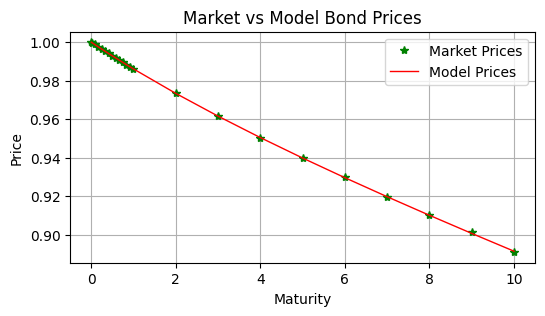

In [7]:
# Function to predict prices with calibrated parameters
def predict_prices(maturities, lambda_r, r_bar, r0):
    predicted_prices = []
    for T in maturities:
        t = 0  # Assuming current time is 0
        P_model = np.exp(b0(T, t, lambda_r, sigma_r, r_bar) + br(T, t, lambda_r) * r0)
        predicted_prices.append(P_model)
    return np.array(predicted_prices)

# Calculate predicted prices
predicted_prices = predict_prices(maturities, lambda_r_ls, r_bar_ls, r0_ls)
market_prices = np.exp(-np.array(zc_yields) * np.array(maturities))

# Compute RMSE
rmse = np.sqrt(np.mean((market_prices - predicted_prices) ** 2))

print(f'RMSE: {rmse:.6f}')

# Plot observed vs predicted prices
plt.figure(figsize=(6, 3))
plt.plot(maturities, market_prices, '*', label='Market Prices', color='green')
plt.plot(maturities, predicted_prices, '-', label='Model Prices', color='red', linewidth=1)
plt.xlabel('Maturity')
plt.ylabel('Price')
plt.title('Market vs Model Bond Prices')
plt.legend()
plt.grid(True)
plt.show()


## Q19) Futures pricing

In [8]:
def calculate_volatility_and_correlation(matrix):
    # Extract variances from the diagonal of the matrix
    var_r = matrix[0, 0]  
    var_delta = matrix[1, 1] 
    var_O = matrix[2, 2] 
    
    # Calculate volatilities as the square roots of the variances
    sigma_r = np.sqrt(var_r)  
    sigma_delta = np.sqrt(var_delta) 
    sigma_O = np.sqrt(var_O) 
    
    # Extract covariances from the off-diagonal elements of the matrix
    cov_r_delta = matrix[0, 1]  
    cov_r_log_O = matrix[0, 2]
    cov_delta_log_O = matrix[1, 2]
    
    # Calculate correlations by dividing the covariances by the product of the respective volatilities
    rho_r_delta = cov_r_delta / (sigma_r * sigma_delta)  
    rho_r_O = cov_r_log_O / (sigma_r * sigma_O)  
    rho_delta_O = cov_delta_log_O / (sigma_delta * sigma_O) 
    
    return sigma_r, sigma_delta, sigma_O, rho_r_delta, rho_r_O, rho_delta_O

# Define the quadratic variation matrix
matrix = np.array([
    [0.000529, 0.00003312, 0.44712],  # First row: variance of r, covariance between r and delta, covariance between r and log(O)
    [0.00003312, 0.000144, 0.08352],  # Second row: covariance between delta and r, variance of delta, covariance between delta and log(O)
    [0.44712, 0.08352, 576]           # Third row: covariance between log(O) and r, covariance between log(O) and delta, variance of log(O)
]) * 1e-4 

# Calculate the volatilities and correlations
sigma_r, sigma_delta, sigma_O, rho_r_delta, rho_r_O, rho_delta_O = calculate_volatility_and_correlation(matrix)

# Print the calculated volatilities
print(f'Sigma_r: {sigma_r}')
print(f'Sigma_delta: {sigma_delta}')
print(f'Sigma_O: {sigma_O}')

# Print the calculated correlations
print(f'Rho_r_delta: {rho_r_delta}')
print(f'Rho_r_log_O: {rho_r_O}')
print(f'Rho_delta_log_O: {rho_delta_O}')


Sigma_r: 0.00023
Sigma_delta: 0.00012
Sigma_O: 0.24000000000000002
Rho_r_delta: 0.12
Rho_r_log_O: 0.8099999999999999
Rho_delta_log_O: 0.29


### Futures Price Calculation

$$
f_{\text{price}}(t, T, r_t, \delta_t, O_t, \phi_0, \phi_r, \phi_\delta) = \exp \left( \phi_0 (T - t) + \phi_r (T - t) \cdot r_t + \phi_\delta (T - t) \cdot \delta_t \right) \cdot O_t
$$


In [9]:
def futures_price(t, T, rt, delta_t, Ot, phi_0, phi_r, phi_delta):
    exponent = phi_0 * (T - t) + phi_r * (T - t) * rt + phi_delta * (T - t) * delta_t        
    return np.exp(exponent) * Ot

$$ \phi_r(\tau, \lambda_r) = \frac{1 - \exp(-\lambda_r \cdot \tau)}{\lambda_r} $$


In [10]:
def phi_r(tau, lambda_r):
    return (1 - np.exp(-lambda_r * tau)) / lambda_r



$$ \phi_\delta(\tau, \lambda_\delta) = \frac{\exp(-\lambda_s \cdot \tau) - 1}{\lambda_s  }$$ 


In [11]:
def phi_delta(tau, lambda_delta):
    return (np.exp(-lambda_delta * tau) - 1) / lambda_delta


$$
\phi_0(\tau, \lambda_r, \lambda_\delta, \sigma_r, \sigma_\delta, \sigma_O, \bar{\delta}, \bar{r}) = \int_0^\tau \left[ \frac{1}{2} \left( \phi_\delta(s, \lambda_\delta) \left( 2 \lambda_\delta \bar{\delta} + \|\sigma_O\|^2 \phi_\delta(s, \lambda_\delta) + 2 \sigma_\delta^T \sigma_O \right) + 2 \phi_r(s, \lambda_r) \left( \lambda_r \bar{r} + \phi_\delta(s, \lambda_\delta) \sigma_r^T \sigma_O + \sigma_r^T \sigma_\delta \right) + \|\sigma_r\|^2 \phi_r^2(s, \lambda_r) \right) \right] ds
$$


In [12]:
def phi_0(tau, lambda_r, lambda_delta, sigma_r, sigma_delta, sigma_O, delta_bar, bar_r):
    def to_integrate(s):
        phi_delta_s = phi_delta(s, lambda_delta)
        phi_r_s = phi_r(s, lambda_r)
        term1 = phi_delta_s * (2 * lambda_delta * delta_bar + (np.linalg.norm(sigma_O) ** 2) * phi_delta_s + 2 * np.dot(sigma_delta.T, sigma_O))
        term2 = 2 * phi_r_s * (lambda_r * bar_r + phi_delta_s * np.dot(sigma_r.T, sigma_O) + np.dot(sigma_r.T, sigma_delta))
        term3 = (np.linalg.norm(sigma_r) ** 2) * (phi_r_s ** 2)
        return 0.5 * (term1 + term2 + term3)
    
    phi0, _ = integrate.quad(to_integrate, 0, tau)
    return phi0

In [13]:
def objective(params, futures_prices, maturities, r0, r_bar, lambda_r, sigma_r, sigma_delta, sigma_O, O0):
    lambda_delta, delta_bar, delta_0 = params
    t = 0
    r_t = r0 
    errors = []
    for T, f_observed in zip(maturities, futures_prices):
        phi_delta_ = phi_delta(T, lambda_delta)
        phi_r_ = phi_r(T, lambda_r)
        phi_0_ = phi_0(T, lambda_r, lambda_delta, sigma_r, sigma_delta, sigma_O, delta_bar, r_bar)
        f_theoretical = futures_price(t, T, r_t, delta_0, O0 , phi_0_, phi_r_, phi_delta_)
        # print(f'Theoretical Futures Price: {f_theoretical}')
        # print(f'Observed Futures Price: {f_observed}\n')
        error = f_observed - f_theoretical
        errors.append(error)
    # return np.sum(np.abs(errors)) # MAE
    return np.sum(np.square(errors)) # MSE

# Initial guesses for parameters
initial_guess = [0.4, 0.2, 0.001]
# Initial spot price of oil in dollars per barrel
init_spot_price_oil_pb = 80

# Minimize the objective function
args=(futures_prices, maturities, r0_ls, r_bar_ls, lambda_r_ls, sigma_r, sigma_delta, sigma_O, init_spot_price_oil_pb)
result = minimize(objective, initial_guess, args=args , method='Nelder-Mead')

# Extract the calibrated parameters
lambda_delta_ls, delta_bar_ls, delta_0_ls = result.x

print(f"Calibrated parameters:")
print(f"lambda_delta: {lambda_delta_ls}")
print(f"delta_bar: {delta_bar_ls}")
print(f"delta_0: {delta_0_ls}")


Calibrated parameters:
lambda_delta: 1.3225447236519177
delta_bar: 0.026003166652844467
delta_0: 0.00403890287809797


RMSE: 0.160878


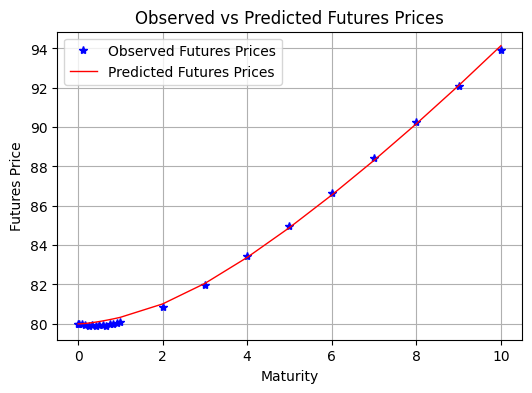

In [15]:
# Function to predict futures prices with calibrated parameters
def predict_futures_prices(maturities, r0, lambda_r, lambda_delta, delta_bar, delta_0, O0):
    predicted_prices = []
    for T in maturities:
        t = 0
        phi_delta_ = phi_delta(T, lambda_delta)
        phi_r_ = phi_r(T, lambda_r)
        phi_0_ = phi_0(T, lambda_r, lambda_delta, sigma_r, sigma_delta, sigma_O, delta_bar, r_bar_ls)
        f_theoretical = futures_price(t, T, r0, delta_0, O0, phi_0_, phi_r_, phi_delta_)
        predicted_prices.append(f_theoretical)
    return np.array(predicted_prices)

# Calculate predicted futures prices
predicted_prices = predict_futures_prices(maturities, r0_ls, lambda_r_ls, lambda_delta_ls, delta_bar_ls, delta_0_ls, init_spot_price_oil_pb)

# Compute RMSE
rmse = np.sqrt(np.mean((futures_prices - predicted_prices) ** 2))

print(f'RMSE: {rmse:.6f}')

# Plot observed vs predicted futures prices
plt.figure(figsize=(6, 4))
plt.plot(maturities, futures_prices, '*', label='Observed Futures Prices', color='blue')
plt.plot(maturities, predicted_prices, '-', label='Predicted Futures Prices', color='red', linewidth=1)
plt.xlabel('Maturity')
plt.ylabel('Futures Price')
plt.title('Observed vs Predicted Futures Prices')
plt.legend()
plt.grid(True)
plt.show()


## Q20) Storage options

$$
\psi_\delta(s) = \frac{e^{-\lambda_\delta s} - 1}{\lambda_\delta}

$$



$$
\psi_0(s) = \frac{1}{4 \lambda_\delta^3} \left( -e^{-2 \lambda_\delta s} (e^{\lambda_\delta s} - 1) \left( (3 e^{\lambda_\delta s} - 1) \|\sigma_\delta\|^2 - 4 e^{\lambda_\delta s} \lambda_\delta \bar{\delta} \lambda_\delta^2 + 4 e^{\lambda_\delta s} \lambda_\delta \sigma_\delta^T \sigma_O \right) + 2 \lambda_\delta s \left( \|\sigma_\delta\|^2 - 2 \bar{\delta} \lambda_\delta^2 + 2 \lambda_\delta \sigma_\delta^T \sigma_O \right) \right)
$$


$$
H\left(\delta_{T_0}\right)=e^{\psi_0(\Delta)+\psi_\delta(\Delta) \delta_{T_0}}-1-\alpha \int_0^{\Delta} e^{\psi_0(\tau)+\psi_\delta(\tau) \delta_{T_0}} d \tau
$$

In [16]:
def psi_delta(tau, lambda_delta):
    return (np.exp(-lambda_delta * tau) - 1) / lambda_delta

def psi_0(tau, lambda_delta, sigma_delta, delta_bar, rho_delta_O):
    term1 = -np.exp(-2 * lambda_delta * tau)
    term2 = (np.exp(lambda_delta * tau) - 1)
    term3 = (3 * np.exp(lambda_delta * tau) - 1) * np.linalg.norm(sigma_delta)**2 - 4 * np.exp(lambda_delta * tau) * delta_bar * lambda_delta**2 + 4 * np.exp(lambda_delta * tau) * lambda_delta * rho_delta_O / (sigma_O * sigma_delta)
    term4 = 2 * lambda_delta * tau * (np.linalg.norm(sigma_delta)**2 - 2 * delta_bar * lambda_delta**2 + 2 * lambda_delta * rho_delta_O / (sigma_O * sigma_delta))
    
    return (term1 * term2 * term3 + term4) / (4 * lambda_delta**3)
# Define the H function
def H(delta_T0, alpha, Delta, sigma_delta=sigma_delta, lambda_delta=lambda_delta_ls, delta_bar=delta_bar_ls, rho_delta_O=rho_delta_O):
    exp_term = np.exp(psi_0(Delta, sigma_delta, sigma_delta, delta_bar, rho_delta_O) + psi_delta(Delta, lambda_delta) * delta_T0)
    to_integrate = lambda tau: np.exp(psi_0(tau, lambda_delta, sigma_delta, delta_bar, rho_delta_O) + psi_delta(tau, lambda_delta) * delta_T0)
    integral_value, _ = integrate.quad(to_integrate, 0, Delta)
    H_value = exp_term - 1 - alpha * integral_value
    return H_value

The payoff at the start date is : 
$ H\left(\delta_{T_0}\right)^+ = max (0, H\left(\delta_{T_0}\right))$

In [17]:
# Compute the payoff at T0
def payoff_at_T0(delta_T0, alpha, Delta, sigma_delta=sigma_delta, lambda_delta=lambda_delta_ls, delta_bar=delta_bar_ls, rho_delta_O=rho_delta_O):
    H_value = H(delta_T0, alpha, Delta, sigma_delta=sigma_delta, lambda_delta=lambda_delta, delta_bar=delta_bar, rho_delta_O=rho_delta_O)
    payoff_T0 = max(0, H_value)

    return payoff_T0

Now let's find the critical value of the convenience yield. We proved that $\delta^{+}$ satisfies $H(\delta^{+})=0 $


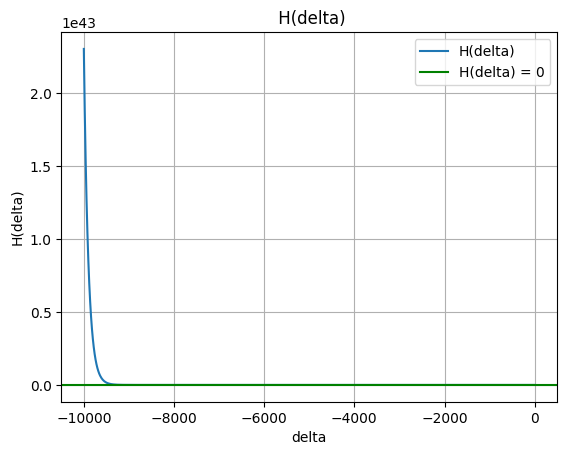

Critical Convenience Yield (delta*): 50.456406199198106


In [18]:
bracket = [-10000, 1] # We can adjust the bracket if brentq method
x0 = -1 # We can adjust the initial guess if newton method

def find_critical_delta(Delta, alpha):
    # result = root_scalar(H, args=(Delta, alpha), bracket=bracket, method='brentq')
    result = root_scalar(H, args=(Delta, alpha), x0=x0, method='newton')
    return result.root if result.converged else None

alpha = 0.01
Delta = 1/4
deltas = np.linspace(bracket[0], bracket[1], 1000)
H_values = [H(delta, Delta, alpha, sigma_delta=sigma_delta, lambda_delta=lambda_delta_ls, delta_bar=delta_bar_ls, rho_delta_O=rho_delta_O) for delta in deltas]

plt.plot(deltas, H_values, label='H(delta)')
plt.axhline(0, color='g', label='H(delta) = 0')
plt.xlabel('delta')
plt.ylabel('H(delta)')
plt.title(' H(delta)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate critical delta*
delta_star = find_critical_delta(Delta, alpha)
print(f"Critical Convenience Yield (delta*): {delta_star}")

Now we need to find the initial price of the storage option:
$$
\mathbb{E}_t^{\mathbb{Q}}\left[e^{-\int_t^{T_0} r_u d u} \mathcal{P}_{T_0}^{+}\right]=\mathcal{O}_t \mathbb{E}_t^{\overline{\mathbb{Q}}}\left[e^{-\int_t^{T_0} \delta_u d u} H\left(\delta_{T_0}\right)^{+}\right]
$$

So evaluating at $t=T_0$ gives : 

$$
\mathbb{E}_{T_0}^{\mathbb{Q}}\left[e^{-\int_{T_0}^{T_0} r_u d u} \mathcal{P}_{T_0}^{+}\right]=\mathcal{O}_{T_0} \mathbb{E}_{T_0}^{\overline{\mathbb{Q}}}\left[e^{-\int_{T_0}^{T_0} \delta_u d u} H\left(\delta_{T_0}\right)^{+}\right]
$$ 
which gives :
<!-- $$
\mathcal{P}_{T_0}^{+} = {O}_{T_0} H(\delta_{T_0})^{+}
$$ -->

$$ 
P_0 = {O}_{0} * e^{-\int_0^{T_0} r_u du } * H\left(\delta_{T_0}\right)^+
$$


In [19]:
# Function to simulate r_t
def simulate_r_t(lambda_r, r_bar, sigma_r, r0, T0=0.5, dt=0.01):
    N = int(T0 / dt)  # Number of steps
    r_t = np.zeros(N + 1)
    r_t[0] = r0
    for t in range(1, N + 1):
        dB = np.random.normal(0, np.sqrt(dt), size=1)
        r_t[t] = r_t[t - 1] + lambda_r * (r_bar - r_t[t - 1]) * dt + sigma_r * dB
    return r_t

# Function to compute P0 using precomputed r_t
def compute_P0_from_r_t(O_0, r_t, alpha, Delta, sigma_delta, lambda_delta, delta_bar, rho_delta_O, delta_T0, dt=0.01):
    # Integrate r_t over [0, T0]
    integral = np.trapz(r_t, dx=dt)
    # Compute payoff at T0
    payoff_T0 = payoff_at_T0(delta_T0, alpha, Delta, sigma_delta, lambda_delta, delta_bar, rho_delta_O)
    # Compute P0
    P0 = O_0 * np.exp(-integral) * payoff_T0
    return P0


## Q21) Sensitivity & Dependence 

/var/folders/wf/z0mdfp611sjdhykwzsyv38wm0000gn/T/ipykernel_31307/1313505640.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_t[t] = r_t[t - 1] + lambda_r * (r_bar - r_t[t - 1]) * dt + sigma_r * dB


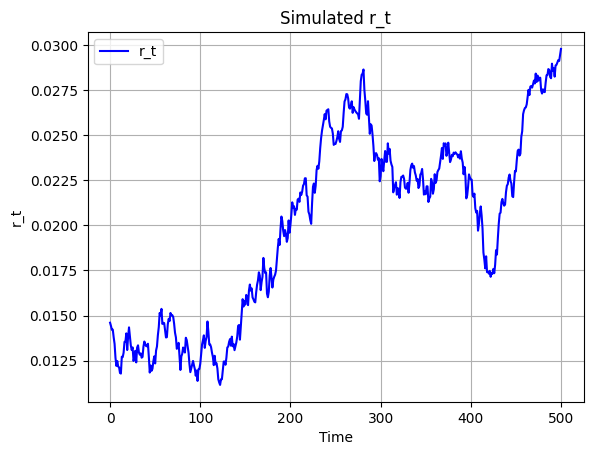

Benchmark P0: 3.6019105582338146e+138


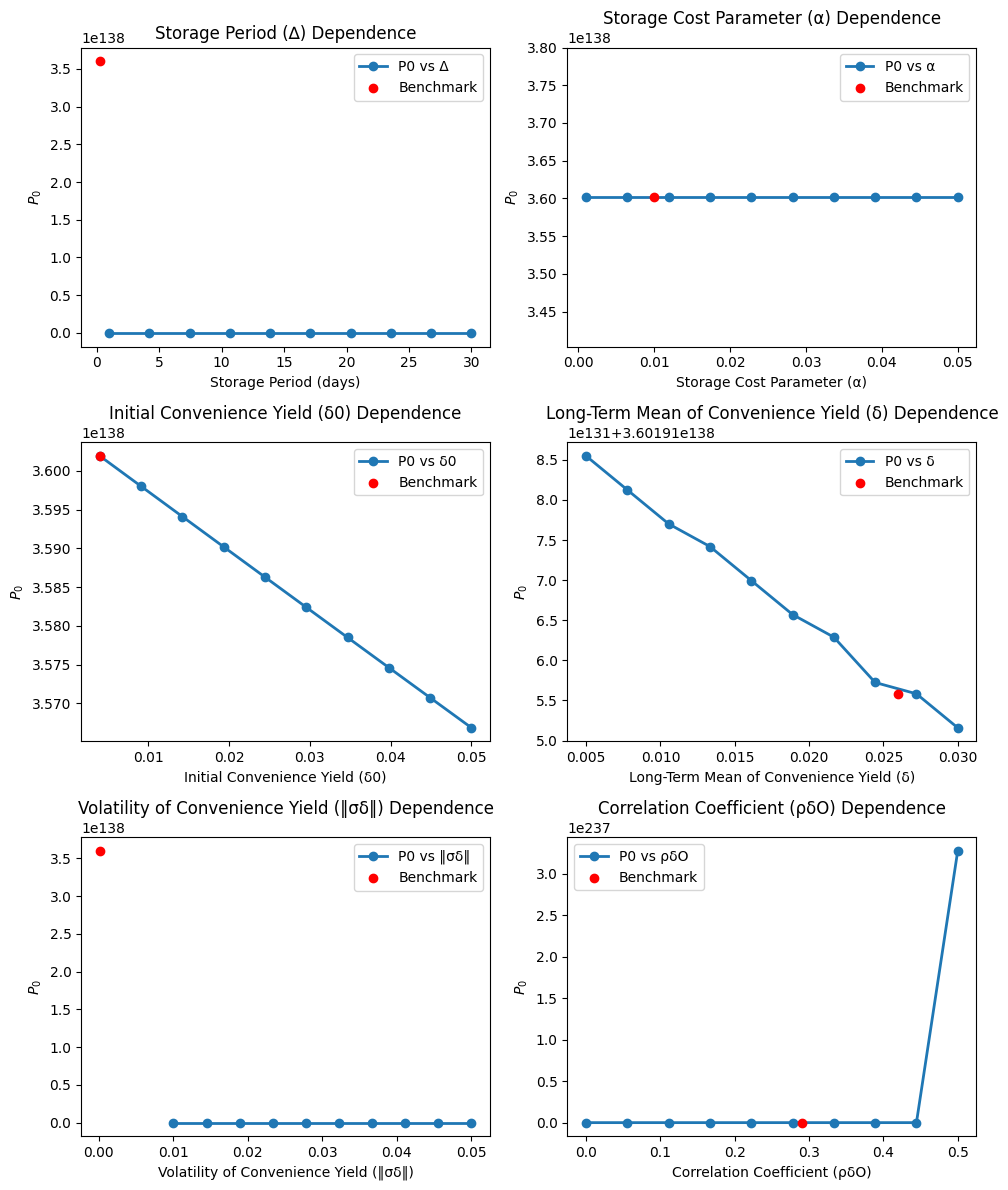

In [20]:
def psi_delta(tau, lambda_delta):
    return (np.exp(-lambda_delta * tau) - 1) / lambda_delta

def psi_0(tau, lambda_delta, sigma_delta, delta_bar, rho_delta_O):
    term1 = -np.exp(-2 * lambda_delta * tau)
    term2 = (np.exp(lambda_delta * tau) - 1)
    term3 = (3 * np.exp(lambda_delta * tau) - 1) * np.linalg.norm(sigma_delta)**2 - 4 * np.exp(lambda_delta * tau) * delta_bar * lambda_delta**2 + 4 * np.exp(lambda_delta * tau) * lambda_delta * rho_delta_O / (sigma_O * sigma_delta)
    term4 = 2 * lambda_delta * tau * (np.linalg.norm(sigma_delta)**2 - 2 * delta_bar * lambda_delta**2 + 2 * lambda_delta * rho_delta_O / (sigma_O * sigma_delta))
    
    return (term1 * term2 * term3 + term4) / (4 * lambda_delta**3)
# Define the H function
def H(delta_T0, alpha, Delta, sigma_delta=sigma_delta, lambda_delta=lambda_delta_ls, delta_bar=delta_bar_ls, rho_delta_O=rho_delta_O):
    exp_term = np.exp(psi_0(Delta, sigma_delta, sigma_delta, delta_bar, rho_delta_O) + psi_delta(Delta, lambda_delta) * delta_T0)
    to_integrate = lambda tau: np.exp(psi_0(tau, lambda_delta, sigma_delta, delta_bar, rho_delta_O) + psi_delta(tau, lambda_delta) * delta_T0)
    integral_value, _ = integrate.quad(to_integrate, 0, Delta)
    H_value = exp_term - 1 - alpha * integral_value
    return H_value
# Compute the payoff at T0
def payoff_at_T0(delta_T0, alpha, Delta, sigma_delta=sigma_delta, lambda_delta=lambda_delta_ls, delta_bar=delta_bar_ls, rho_delta_O=rho_delta_O):
    H_value = H(delta_T0, alpha, Delta, sigma_delta=sigma_delta, lambda_delta=lambda_delta, delta_bar=delta_bar, rho_delta_O=rho_delta_O)
    payoff_T0 = max(0, H_value)

    return payoff_T0
# Function to simulate r_t
def simulate_r_t(lambda_r, r_bar, sigma_r, r0, T0=0.5, dt=0.01):
    N = int(T0 / dt)  # Number of steps
    r_t = np.zeros(N + 1)
    r_t[0] = r0
    for t in range(1, N + 1):
        dB = np.random.normal(0, np.sqrt(dt), size=1)
        r_t[t] = r_t[t - 1] + lambda_r * (r_bar - r_t[t - 1]) * dt + sigma_r * dB
    return r_t

# Function to compute P0 using precomputed r_t
def compute_P0_from_r_t(O_0, r_t, alpha, Delta, sigma_delta, lambda_delta, delta_bar, rho_delta_O, delta_T0, dt=0.01):
    # Integrate r_t over [0, T0]
    integral = np.trapz(r_t, dx=dt)
    # Compute payoff at T0
    payoff_T0 = payoff_at_T0(delta_T0, alpha, Delta, sigma_delta, lambda_delta, delta_bar, rho_delta_O)
    # Compute P0
    P0 = O_0 * np.exp(-integral) * payoff_T0
    return P0


# Parameters
O_0 = 80  # Initial spot price of oil in dollars per barrel
lambda_r = 0.2991437388948194
r_bar = 0.010033839633324947
r0 = 0.014603967286584005
sigma_r = 0.015
sigma_delta = 0.00012
lambda_delta = 1.3225447236519177
delta_bar_benchmark = 0.026003166652844467
delta_T0_benchmark = 0.00403890287809797
rho_delta_O = 0.29

T0 = 0.5
Delta = 1/4 
alpha = 0.01
dt = 0.001

# Parameter ranges
Delta_range = np.linspace(1, 30, 10) / 365  # Days to fraction of year
alpha_range = np.linspace(0.001, 0.05, 10)
delta_T0_range = np.linspace(0.004, 0.05, 10)
delta_bar_range = np.linspace(0.005, 0.03, 10)
sigma_delta_range = np.linspace(0.01, 0.05, 10)
rho_delta_O_range = np.linspace(0, 0.5, 10)

# Simulate r_t once
r_t_simulation = simulate_r_t(lambda_r, r_bar, sigma_r, r0, T0, dt)
plt.plot(r_t_simulation, label='r_t', color='blue')
plt.xlabel('Time')
plt.ylabel('r_t')
plt.title('Simulated r_t')
plt.legend()
plt.grid(True)
plt.show()

# Storage for results
P0_Delta = []
P0_alpha = []
P0_delta_T0 = []
P0_delta_bar = []
P0_sigma_delta = []
P0_rho_delta_O = []

# Compute P0 for each parameter range
for Delta_ in Delta_range:
    P0_Delta.append(compute_P0_from_r_t(O_0, r_t_simulation, alpha, Delta_, sigma_delta, lambda_delta, delta_bar_benchmark, rho_delta_O, delta_T0_benchmark, dt))

for alpha_ in alpha_range:
    P0_alpha.append(compute_P0_from_r_t(O_0, r_t_simulation, alpha_, Delta, sigma_delta, lambda_delta, delta_bar_benchmark, rho_delta_O, delta_T0_benchmark, dt))

for delta_T0_ in delta_T0_range:
    P0_delta_T0.append(compute_P0_from_r_t(O_0, r_t_simulation, alpha, Delta, sigma_delta, lambda_delta, delta_bar_benchmark, rho_delta_O, delta_T0_, dt))

for delta_bar_ in delta_bar_range:
    P0_delta_bar.append(compute_P0_from_r_t(O_0, r_t_simulation, alpha, Delta, sigma_delta, lambda_delta, delta_bar_, rho_delta_O, delta_T0_benchmark, dt))

for sigma_delta_ in sigma_delta_range:
    P0_sigma_delta.append(compute_P0_from_r_t(O_0, r_t_simulation, alpha, Delta, sigma_delta_, lambda_delta, delta_bar_benchmark, rho_delta_O, delta_T0_benchmark, dt))

for rho_delta_O_ in rho_delta_O_range:
    P0_rho_delta_O.append(compute_P0_from_r_t(O_0, r_t_simulation, alpha, Delta, sigma_delta, lambda_delta, delta_bar_benchmark, rho_delta_O_, delta_T0_benchmark, dt))

# Compute benchmark P0 for the calibrated model
P0_benchmark = compute_P0_from_r_t(O_0, r_t_simulation, alpha, Delta, sigma_delta, lambda_delta, delta_bar_benchmark, rho_delta_O, delta_T0_benchmark, dt)
print(f"Benchmark P0: {P0_benchmark}")
# Plotting
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

# Delta Dependence
axs[0, 0].plot(Delta_range * 365, P0_Delta, 'o-', lw=2, label='P0 vs Δ')
axs[0, 0].scatter(Delta, P0_benchmark, color='r', zorder=5, label='Benchmark')  # Delta benchmark at 14 days
axs[0, 0].set_title('Storage Period (∆) Dependence')
axs[0, 0].set_xlabel('Storage Period (days)')
axs[0, 0].set_ylabel('$P_0$')
axs[0, 0].legend()

# Alpha Dependence
axs[0, 1].plot(alpha_range, P0_alpha, 'o-', lw=2, label='P0 vs α')
axs[0, 1].scatter(alpha, P0_benchmark, color='r', zorder=5, label='Benchmark')  # Alpha benchmark at 0.01
axs[0, 1].set_title('Storage Cost Parameter (α) Dependence')
axs[0, 1].set_xlabel('Storage Cost Parameter (α)')
axs[0, 1].set_ylabel('$P_0$')
axs[0, 1].legend()

# Delta_T0 Dependence
axs[1, 0].plot(delta_T0_range, P0_delta_T0, 'o-', lw=2, label='P0 vs δ0')
axs[1, 0].scatter(delta_T0_benchmark, P0_benchmark, color='r', zorder=5, label='Benchmark')  # Delta_T0 benchmark
axs[1, 0].set_title('Initial Convenience Yield (δ0) Dependence')
axs[1, 0].set_xlabel('Initial Convenience Yield (δ0)')
axs[1, 0].set_ylabel('$P_0$')
axs[1, 0].legend()

# Delta_bar Dependence
axs[1, 1].plot(delta_bar_range, P0_delta_bar, 'o-', lw=2, label='P0 vs δ')
axs[1, 1].scatter(delta_bar_benchmark, P0_benchmark, color='r', zorder=5, label='Benchmark')  # Delta_bar benchmark
axs[1, 1].set_title('Long-Term Mean of Convenience Yield (δ) Dependence')
axs[1, 1].set_xlabel('Long-Term Mean of Convenience Yield (δ)')
axs[1, 1].set_ylabel('$P_0$')
axs[1, 1].legend()

# Sigma_delta Dependence
axs[2, 0].plot(sigma_delta_range, P0_sigma_delta, 'o-', lw=2, label='P0 vs ‖σδ‖')
axs[2, 0].scatter(sigma_delta, P0_benchmark, color='r', zorder=5, label='Benchmark')  # Sigma_delta benchmark
axs[2, 0].set_title('Volatility of Convenience Yield (‖σδ‖) Dependence')
axs[2, 0].set_xlabel('Volatility of Convenience Yield (‖σδ‖)')
axs[2, 0].set_ylabel('$P_0$')
axs[2, 0].legend()

# Rho_delta_O Dependence
axs[2, 1].plot(rho_delta_O_range, P0_rho_delta_O, 'o-', lw=2, label='P0 vs ρδO')
axs[2, 1].scatter(rho_delta_O, P0_benchmark, color='r', zorder=5, label='Benchmark')  # Rho_delta_O benchmark
axs[2, 1].set_title('Correlation Coefficient (ρδO) Dependence')
axs[2, 1].set_xlabel('Correlation Coefficient (ρδO)')
axs[2, 1].set_ylabel('$P_0$')
axs[2, 1].legend()

plt.tight_layout()
plt.show()
